# 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# импорт необходимых библиотек
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets, transforms

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split

from torchvision.datasets import ImageFolder 


In [ ]:
# разархивация архива 
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 25004/25004 [00:33<00:00, 742.34it/s]


In [ ]:
# создание датасета с помощью ImageFolder 
transform = transforms.Compose([
        transforms.Resize([400, 400]), 
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

cats_dogs = datasets.ImageFolder('/content/cats_dogs/train', transform = transform) 


In [ ]:
train_size = int(0.8 * len(cats_dogs))
test_size = len(cats_dogs) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(cats_dogs, [train_size, test_size])

In [ ]:
# разбиение на train and test
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


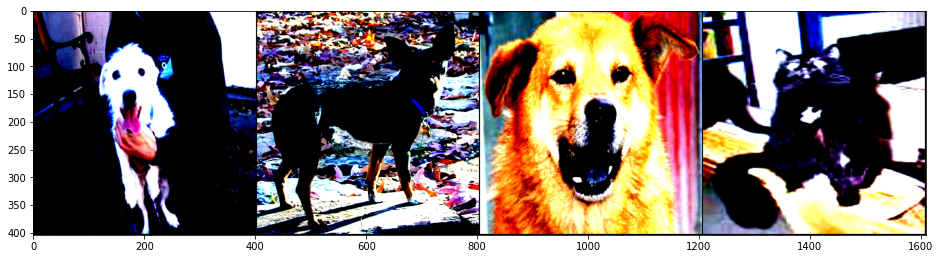

In [ ]:
# посмотрим на примеры изначальных изображений изображений
images, labels = next(iter(train_loader))

# we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.

plt.figure(figsize=(16,24))

grid_imgs = torchvision.utils.make_grid(images[:4])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np_grid_imgs.transpose(1, 2, 0))


# for i in range(4):
#   plt.imshow(images[i].permute(1, 2, 0))
#   plt.show()


In [ ]:
# построение модели
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# torch.Size([32, 32, 31, 31])
input_size = 32*31*31
model = nn.Sequential(
    nn.Conv2d( 3, 5, kernel_size = 3, padding = 1),
    nn.BatchNorm2d(5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(5, 16, 5),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 32, 5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(3),


    nn.Flatten(),

    nn.Dropout(p = 0.1),
    nn.Linear(input_size, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 2)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# X_batch, y_batch = next(iter(train_loader))
# model(X_batch).shape

torch.Size([32, 32, 31, 31])

In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(5, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.1, inplace=False)
  (14): Linear(in_features=30752, out_features=32, bias=True)
  (15): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU()
  (17): Li

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# обучение
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001) 


epoches = 10

losses = []
for epoch in range(1, epoches+1): 

    epoch_loss = 0
    train_accuracy = 0

    for  X_batch, y_batch in train_loader:
      X_batch = X_batch.to(device = device) 
      y_batch = y_batch.to(device = device)
    
      out = model(X_batch)
      loss = loss_fn(out, y_batch)

      loss.backward() 
      optimizer.step() 
      optimizer.zero_grad()
      
      # считаем acc и loss на тренировочном множестве
      train_accuracy += accuracy_score(torch.argmax(nn.Softmax(dim = 1)(out), axis = 1).cpu(), y_batch.cpu())
      epoch_loss += loss.item()

    print(f"Epoch: {epoch}; Train Loss: {epoch_loss/len(train_loader)}")
    print(f"Train Accuracy: {train_accuracy/len(train_loader)}")

    


Epoch: 1; Train Loss: 0.5348716102600097
Train Accuracy: 0.7231
Epoch: 2; Train Loss: 0.445511701130867
Train Accuracy: 0.79165
Epoch: 3; Train Loss: 0.3684312298297882
Train Accuracy: 0.8383
Epoch: 4; Train Loss: 0.29731848477125167
Train Accuracy: 0.8754
Epoch: 5; Train Loss: 0.2222125197470188
Train Accuracy: 0.91005
Epoch: 6; Train Loss: 0.1651404187232256
Train Accuracy: 0.93385
Epoch: 7; Train Loss: 0.1245527026951313
Train Accuracy: 0.9543
Epoch: 8; Train Loss: 0.08934334311187267
Train Accuracy: 0.9685
Epoch: 9; Train Loss: 0.07373842292129994
Train Accuracy: 0.97325
Epoch: 10; Train Loss: 0.06400953629724682
Train Accuracy: 0.97905


In [ ]:
# сохранение модели
torch.save(model.state_dict(), "cats_dods_model")

In [ ]:
# # график для функции потерь на тестовом множестве
# plt.plot(epoch_loss, label = 'training loss')
# plt.legend()

# # график для accuracy на тестовом множестве
# plt.plot(epoch_accuracy, label = 'training accuracy')
# plt.legend()

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 256)

In [ ]:
# демонстрация работы на тестовом множестве
test_acc = 0
for x_holdout, y_holdout in test_loader:
    x_holdout = x_holdout.to(device)
    y_holdout = y_holdout.to(device)
    preds = torch.argmax(nn.Softmax(dim = 1)(model(x_holdout)), dim = 1)

    test_acc += accuracy_score(preds.cpu(), y_holdout.cpu())

In [ ]:
# accuracy
print('Test Accuracy', test_acc/len(test_loader))

Test Accuracy 0.7927274816176471


In [ ]:
def show_results(predictions, labels, imgs, N): result = list(zip(predictions, labels, imgs)) random.shuffle(result)
predictions, labels, imgs = zip(*result)
fig, ax = plt.subplots(int(N//3), 3, figsize = (15,15))
 k=0
for i in range(int(N//3)):
for j in range(3):
ax[i][j].imshow(imgs[k].numpy().transpose(1,2, 0)) 
ax[i][j].set_title(f"prediction: {predictions[k]}; label = {labels[k]}") 
k += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


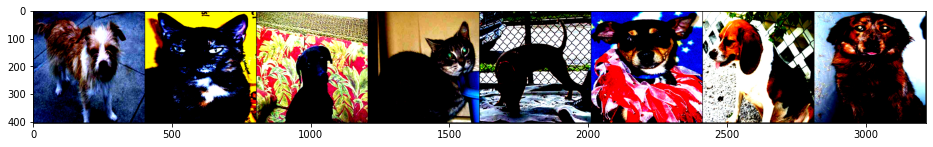

In [ ]:
images_test, labels_test = x_holdout, y_holdout

plt.figure(figsize=(16,24))

grid_imgs = torchvision.utils.make_grid(images_test[:8])
np_grid_imgs = grid_imgs.cpu().numpy()
plt.imshow(np_grid_imgs.transpose(1, 2, 0))



In [ ]:
print(labels_test[:8])

tensor([1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')


In [ ]:
print(preds[:8])

tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(labels_test.cpu(), preds.cpu()))

Confusion Matrix
[[53 16]
 [16 51]]


# 4. Transfer Learning

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] )
    ])

In [ ]:
cats_dogs = datasets.ImageFolder('/content/cats_dogs/train', transform = img_transforms)

In [ ]:
test_size = int(round(0.3 * len(cats_dogs), 0))
train_size = len(cats_dogs) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(cats_dogs, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 256)

In [ ]:
print(f'Num training images: {len(train_loader.dataset)}')
print(f'Num test images: {len(test_loader.dataset)}')

Num training images: 17500
Num test images: 7500


In [ ]:
model_resnet34 = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)


In [ ]:
model = model_resnet34
model.fc = nn.Linear(512, 2)
model.to(device = device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [ ]:
print(model)

In [ ]:
for name, param in model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False


In [ ]:
def train(model = model, optimizer= optimizer, loss_fn = loss_fn, train_loader = train_loader, epochs = 2, device = device):
    for epoch in range(epochs):
        epoch_loss = 0
        acc = 0
        

        model.train()

        for X_batch, y_batch in train_loader:

          X_batch = X_batch.to(device = device)
          y_batch = y_batch.to(device = device)
            
          out = model(X_batch)
          loss = loss_fn(out, y_batch)
          
  
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          epoch_loss += loss.item()
          acc += accuracy_score(torch.argmax(nn.Softmax(dim = 1)(out), dim=1).cpu(), y_batch.cpu())

        print(f"Epoch: {epoch}; Training Loss: {epoch_loss/len(train_loader)}")
        print(f"Training accuracy: {acc/len(train_loader)}")

    return model
        
        


In [ ]:
model = train()

Epoch: 0; Training Loss: 0.2122759722323043
Training accuracy: 0.9448126142595978
Epoch: 1; Training Loss: 0.10526953958029393
Training accuracy: 0.9702108905719509


In [ ]:
accuracy = []
for X_holdout, y_holdout in test_loader:
  X_holdout = X_holdout.to(device = device)
  preds = torch.argmax(nn.Softmax(dim = 1)(model(X_holdout)), dim = 1) 
  
  accuracy.append(accuracy_score(preds.cpu(), y_holdout.cpu()))

In [ ]:
import numpy as np

In [ ]:
print(f"accuracy: {np.mean(accuracy)}")

accuracy: 0.9788925438596491
